In [1]:
!pip install kaggle


# Importing Liberaries 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import shutil, os, zipfile
import joblib
import json
from datetime import datetime



# Downloading & Extracting Data 

In [3]:

# os.remove(r"C:\Users\Athar\.kaggle\kaggle.json")

os.makedirs(r"C:\Users\Athar\.kaggle", exist_ok=True)
shutil.copy(
    r"D:\ml_internship\3_sales_forecasting\data\.kaggle\kaggle.json",
    r"C:\Users\Athar\.kaggle\kaggle.json"
)
print(" Copied kaggle.json to the default location.")


 Copied kaggle.json to the default location.


In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting



  0%|          | 0.00/2.70M [00:00<?, ?B/s]
100%|##########| 2.70M/2.70M [00:00<00:00, 336MB/s]


In [5]:



# Define paths
src = "walmart-recruiting-store-sales-forecasting.zip"  
dest_folder = r"D:\ml_internship\3_sales_forecasting\data"
dest_zip = os.path.join(dest_folder, "walmart-recruiting-store-sales-forecasting.zip")

# Make sure the destination folder exists
os.makedirs(dest_folder, exist_ok=True)

# Move the zip file to the data folder
shutil.move(src, dest_zip)
print(f"Moved to: {dest_zip}")

# Extract the ZIP file inside the data folder
with zipfile.ZipFile(dest_zip, 'r') as zip_f:
    zip_f.extractall(dest_folder)
print(f"Extracted contents to: {dest_folder}")


Moved to: D:\ml_internship\3_sales_forecasting\data\walmart-recruiting-store-sales-forecasting.zip
Extracted contents to: D:\ml_internship\3_sales_forecasting\data


In [6]:
data_folder = r"D:\ml_internship\3_sales_forecasting\data"

# Loop through all files in the data folder
for file in os.listdir(data_folder):
    if file.endswith(".zip"):
        zip_path = os.path.join(data_folder, file)
        extract_folder = data_folder  
        print(f"Extracting {file}...\n")
        
        with zipfile.ZipFile(zip_path, 'r') as zip_f:
            zip_f.extractall(extract_folder)
        print(f"Extracted {file}")

Extracting features.csv.zip...

Extracted features.csv.zip
Extracting sampleSubmission.csv.zip...

Extracted sampleSubmission.csv.zip
Extracting test.csv.zip...

Extracted test.csv.zip
Extracting train.csv.zip...

Extracted train.csv.zip
Extracting walmart-recruiting-store-sales-forecasting.zip...

Extracted walmart-recruiting-store-sales-forecasting.zip


In [7]:
for file in os.listdir(data_folder):
    if file.endswith(".zip"):
        os.remove(os.path.join(data_folder, file))
        print(f"Deleted {file}")

Deleted features.csv.zip
Deleted sampleSubmission.csv.zip
Deleted test.csv.zip
Deleted train.csv.zip
Deleted walmart-recruiting-store-sales-forecasting.zip


# Reading & Exploring Data 

In [8]:
train= pd.read_csv("../data/train.csv")
stores= pd.read_csv("../data/stores.csv")
features= pd.read_csv("../data/features.csv")

In [9]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [13]:
train.Store.value_counts(dropna= False)

Store
13    10474
10    10315
4     10272
1     10244
2     10238
24    10228
27    10225
34    10224
20    10214
6     10211
32    10202
19    10148
31    10142
28    10113
41    10088
11    10062
23    10050
14    10040
40    10017
15     9901
8      9895
39     9878
17     9864
18     9859
26     9854
25     9804
7      9762
12     9705
22     9688
45     9637
21     9582
35     9528
29     9455
16     9443
3      9036
5      8999
9      8867
38     7362
37     7206
44     7169
30     7156
42     6953
43     6751
33     6487
36     6222
Name: count, dtype: int64

In [14]:
train.Dept.value_counts(dropna=False)

Dept
1     6435
16    6435
92    6435
38    6435
40    6435
      ... 
78     235
77     150
65     143
39      16
43      12
Name: count, Length: 81, dtype: int64

In [15]:
train.IsHoliday.value_counts(dropna=False)

IsHoliday
False    391909
True      29661
Name: count, dtype: int64

In [16]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [17]:
stores.Type.value_counts(dropna=False)

Type
A    22
B    17
C     6
Name: count, dtype: int64

In [18]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [19]:
features.IsHoliday.value_counts(dropna=False)

IsHoliday
False    7605
True      585
Name: count, dtype: int64

In [20]:
print(train.shape)
print(stores.shape)

(421570, 5)
(45, 3)


In [21]:
df = train.merge(stores, on='Store', how='left')
df = df.merge(features, on=['Store', 'Date'], how='left', suffixes=('', '_features'))
df['IsHoliday']= df['IsHoliday_features'].fillna(df['IsHoliday'])
df= df.drop(columns= ['IsHoliday_features'])


print(df.shape)
print("\n")
df.head()

(421570, 16)




,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [22]:
df.Store.nunique()

45

In [23]:
print(df['Date'].min())
print(df['Date'].max())

2010-02-05
2012-10-26


# Feature Engineering 

In [24]:
df['Date']= pd.to_datetime(df['Date'])
df['Year']= df['Date'].dt.year
df['Month']= df['Date'].dt.month
df['Day']= df['Date'].dt.day

# Capture seasonal patterns
df['WeekOfYear']= df['Date'].dt.isocalendar().week.astype(int) 

df['IsHoliday']= df['IsHoliday'].astype(int) 

df= df.sort_values(['Store','Dept', 'Date']).reset_index(drop= True) 

# Create lag features 
df['Weekly_Sales_Lag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)  #One week ago
df['Weekly_Sales_Lag2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)  #two weeks ago
df['Weekly_Sales_Lag3']= df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(3)   #Three weeks ago 


# Rolling average (3-week moving average of sales)  Smooth out noise, capture trend
df['Sales_Rolling_Mean_3']= df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(window=3, min_periods=1).mean() 


print("Missing values after lag creation:")
print(df[['Weekly_Sales_Lag1', 'Weekly_Sales_Lag2', 'Sales_Rolling_Mean_3']].isnull().sum())






Missing values after lag creation:
Weekly_Sales_Lag1       3331
Weekly_Sales_Lag2       6625
Sales_Rolling_Mean_3       1
dtype: int64


In [25]:
# Drop rows where key features are NaN
df_clean = df.dropna(subset=['Weekly_Sales_Lag1', 'Weekly_Sales_Lag2', 'Sales_Rolling_Mean_3'])

print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(f"Dropped {df.shape[0] - df_clean.shape[0]} rows ({100*(df.shape[0]-df_clean.shape[0])/df.shape[0]:.1f}%)")

Original shape: (421570, 24)
Cleaned shape: (414945, 24)
Dropped 6625 rows (1.6%)


# Baseline Model 

In [26]:
df_clean['Sales_Rolling_Mean_4']= df_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(4, min_periods=1).mean() 
df_clean['Sales_Rolling_Mean_8']= df_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(8, min_periods=1).mean() 
df_clean['Sales_Rolling_Std_4']= df_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(4, min_periods=1).std() 

# Exponential moving average (reacts faster to changes)
df_clean['Sales_EMA_0.3']= df_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).ewm(alpha=0.3).mean() 






C:\Users\Athar\AppData\Local\Temp\ipykernel_47332\4198060253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Sales_Rolling_Mean_4']= df_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(4, min_periods=1).mean()
C:\Users\Athar\AppData\Local\Temp\ipykernel_47332\4198060253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Sales_Rolling_Mean_8']= df_clean.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(8, min_periods=1).mean()
C:\Users\Athar\AppData\Local\T

In [27]:
df_clean = df_clean.sort_values('Date').reset_index(drop=True)


# subset= [
#     'Store', 'Dept', 'IsHoliday',  'Size',
#     'Temperature', 'Fuel_Price',  'CPI', 'Unemployment', 
#      'Year', 'Month', 'WeekOfYear',
#     'Weekly_Sales_Lag1', 'Weekly_Sales_Lag2', 'Sales_Rolling_Mean_3'
# ]


subset= [
    'Store', 'Dept', 'IsHoliday',  'Size',
    'Temperature', 'Fuel_Price',  'CPI', 'Unemployment', 
     'Year', 'Month', 'WeekOfYear',
    'Weekly_Sales_Lag1', 'Weekly_Sales_Lag2', 'Sales_Rolling_Mean_3', 
    'Sales_Rolling_Mean_4', 'Sales_Rolling_Mean_8', 'Sales_Rolling_Std_4', 'Sales_EMA_0.3'
]
df_clean = df_clean.dropna(subset=subset) 

X = df_clean[subset]
y= df_clean['Weekly_Sales']


X= X.copy() 
store_le= LabelEncoder() 
dept_le = LabelEncoder()

X['Store']= store_le.fit_transform(X['Store'])
X['Dept']= dept_le.fit_transform(X['Dept'])

In [28]:
split_date = '2012-01-01'

# Train on past , validate on the future 
train_mask= df_clean['Date'] < split_date 
val_mask= df_clean['Date'] >= split_date  

X_train, X_val = X[train_mask], X[val_mask]
y_train, y_val = y[train_mask], y[val_mask]  

print(X_train.shape)
print(X_val.shape) 
print(y_train.shape) 
print(y_val.shape)
print("\n")


print(f"Train Period: {df_clean.loc[train_mask,'Date'].min()} to {df_clean.loc[train_mask, 'Date'].max()}")
print(f"Validation Period: {df_clean.loc[val_mask, 'Date'].min()}  to  {df_clean.loc[val_mask,'Date'].max()}")

(287562, 18)
(127378, 18)
(287562,)
(127378,)


Train Period: 2010-02-19 00:00:00 to 2011-12-30 00:00:00
Validation Period: 2012-01-06 00:00:00  to  2012-10-26 00:00:00


In [29]:
rf= RandomForestRegressor(
    n_estimators=100, 
    max_depth=15, 
    random_state=42,
    max_features='sqrt',
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred= rf.predict(X_val)

mae= mean_absolute_error(y_val,y_pred)
rmse= np.sqrt(mean_squared_error(y_val, y_pred))


print(f" Mean Absolute Error: ${mae:,.2f}")
print(f" Root Mean Square Error: ${rmse:,.2f}")

 Mean Absolute Error: $1,542.81
 Root Mean Square Error: $3,370.30


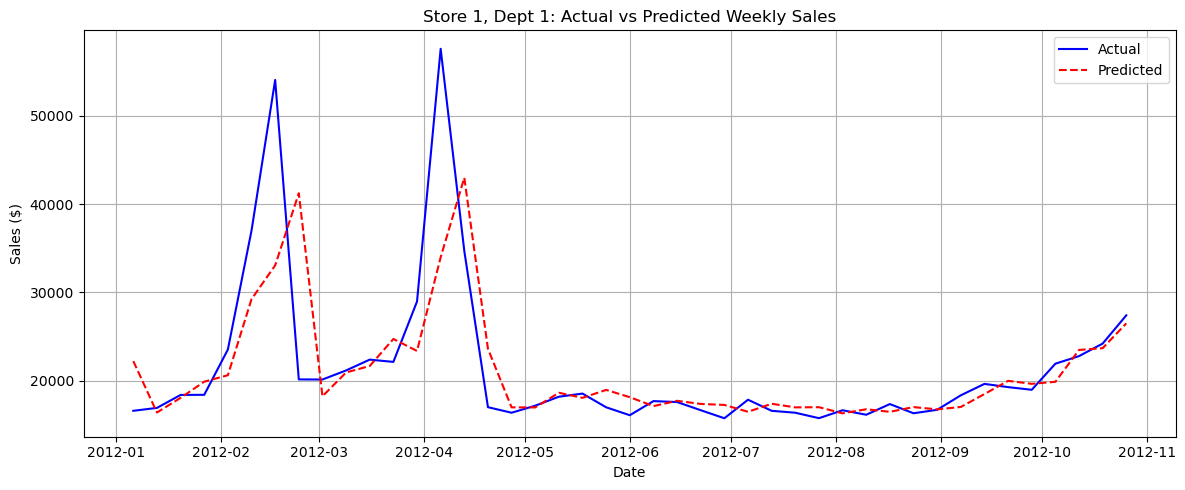

In [66]:
val_df= df_clean[val_mask].copy() 
val_df['Predicted_Sales']= y_pred

sample= val_df[(val_df['Store'] == 1) & (val_df['Dept'] == 1)]


plt.figure(figsize=(12,5))
plt.plot(sample['Date'], sample['Weekly_Sales'], label='Actual', color= 'blue')
plt.plot(sample['Date'], sample['Predicted_Sales'], label= 'Predicted', color= 'red', linestyle='--')



plt.title('Store 1, Dept 1: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend() 
plt.grid(True)
plt.tight_layout() 
plt.savefig('../reports/actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()



# Use XGBoost with time-aware validation

In [31]:

# # Simple XGBoost
# xgb_test = xgb.XGBRegressor(
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     random_state=42,
#     verbosity=0
# )

# # Fit ONLY on train
# xgb_test.fit(X_train, y_train)

# # Predict on val
# pred_test = xgb_test.predict(X_val)

# mae_test = mean_absolute_error(y_val, pred_test)
# rmse_test = np.sqrt(mean_squared_error(y_val, pred_test))

# print(f"✅ CORRECT SPLIT - XGBoost MAE: ${mae_test:,.2f}")
# print(f"✅ CORRECT SPLIT - XGBoost RMSE: ${rmse_test:,.2f}")

In [32]:
# xgb_params={
#     'n_estimators':100, 
#     'max_depth': 5, 
#     'learning_rate': 0.01, 
#     'subsample':0.5,
#     'colsample_bytree':0.5, 
#     'random_state':42, 
#     'objective':'reg:squarederror', 
#     'eval_metric': 'mae'
# }
# xgb_model= xgb.XGBRegressor(**xbg_params)

xgb_model= xgb.XGBRegressor(
    n_estimators= 500, 
    max_depth=10, 
    learning_rate= 0.05, 
    random_state=42, 
    
)
xgb_model.fit(X_train, y_train)
y_pred_xgb= xgb_model.predict(X_val)

mae_xgb= mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb= np.sqrt(mean_squared_error(y_val, y_pred_xgb))


print(f"XGBoost Mean Absolute Error: ${mae_xgb:,.2f}")
print(f"XGBoost Root Mean Square Error: ${rmse_xgb:,.2f}")


XGBoost Mean Absolute Error: $1,442.01
XGBoost Root Mean Square Error: $3,103.90


In [34]:
# Split train into train + early stopping val

X_train_fit, X_train_val, y_train_fit, y_train_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, shuffle=False  # no shuffle!
)

xgb_best = xgb.XGBRegressor(
    n_estimators=1000,        
    max_depth=10,
    learning_rate=0.05,
    random_state=42,
    early_stopping_rounds=20  # stop if no improvement in 20 rounds
)

xgb_best.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_train_val, y_train_val)],
    verbose=False
)

# Predict
y_pred_best = xgb_best.predict(X_val)
mae_best = mean_absolute_error(y_val, y_pred_best)
rmse_best= np.sqrt(mean_squared_error(y_val, y_pred_best))
print(f"Final MAE with early stopping: ${mae_best:,.2f}")
print(f"Final RMSE with early stopping: ${rmse_best:,.2f}")

Final MAE with early stopping: $1,408.34
Final RMSE with early stopping: $3,018.56


# Results 

In [35]:
results = pd.DataFrame(
    {
        'Model': [
            'Random Forest (Baseline)',
             'XGBoost', 
            'XGBoost + Rolling Features',
            'XGBoost + Rolling + Early Stopping'
        ], 
        'MAE': [1621.91, 1474.24, 1442.01, 1408.34],
        'RMSE': [3596.41, 3133.36, 3103.90, 3018.56]
    }
)

results


,Model,MAE,RMSE
0,Random Forest (Baseline),1621.91,3596.41
1,XGBoost,1474.24,3133.36
2,XGBoost + Rolling Features,1442.01,3103.90
3,XGBoost + Rolling + Early Stopping,1408.34,3018.56


In [38]:
# Calculate % improvement vs baseline
baseline_mae= results.loc[0, 'MAE']

results['MAE_Improvement_%']= round((1- results['MAE']/ baseline_mae)*100,2)

results

,Model,MAE,RMSE,MAE_Improvement_%
0,Random Forest (Baseline),1621.91,3596.41,0.00
1,XGBoost,1474.24,3133.36,9.10
2,XGBoost + Rolling Features,1442.01,3103.90,11.09
3,XGBoost + Rolling + Early Stopping,1408.34,3018.56,13.17


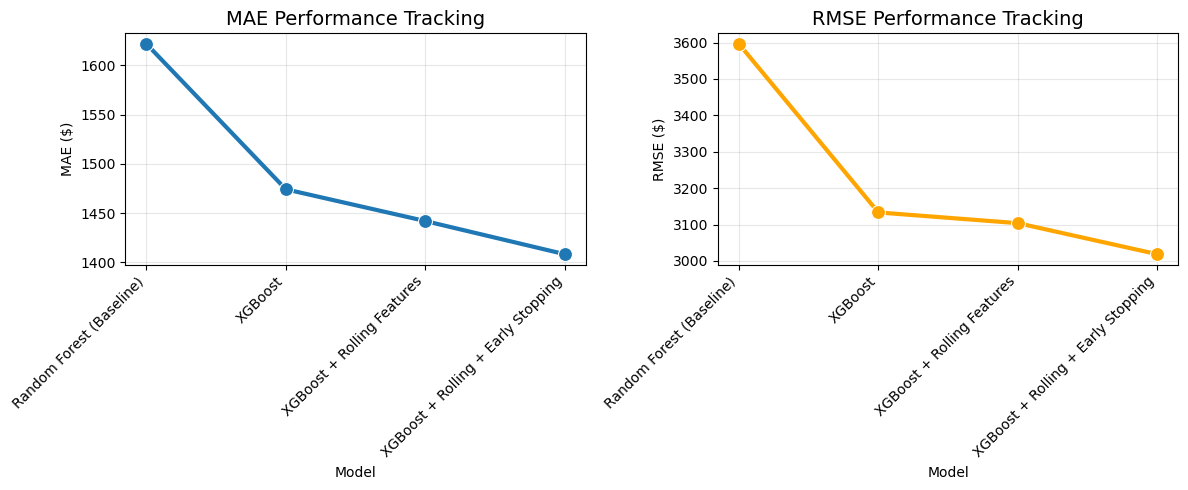

In [67]:
plt.figure(figsize=(12, 5))

# MAE
plt.subplot(1, 2, 1)
sns.lineplot(data=results, x='Model', y='MAE', marker='o', linewidth=3, markersize=10)
plt.title('MAE Performance Tracking', fontsize=14)
plt.ylabel('MAE ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# RMSE
plt.subplot(1, 2, 2)
sns.lineplot(data=results, x='Model', y='RMSE', marker='o', color='orange', linewidth=3, markersize=10)
plt.title('RMSE Performance Tracking', fontsize=14)
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/MAE vs RMSE performance tracking.png', dpi=150, bbox_inches='tight')

plt.show()

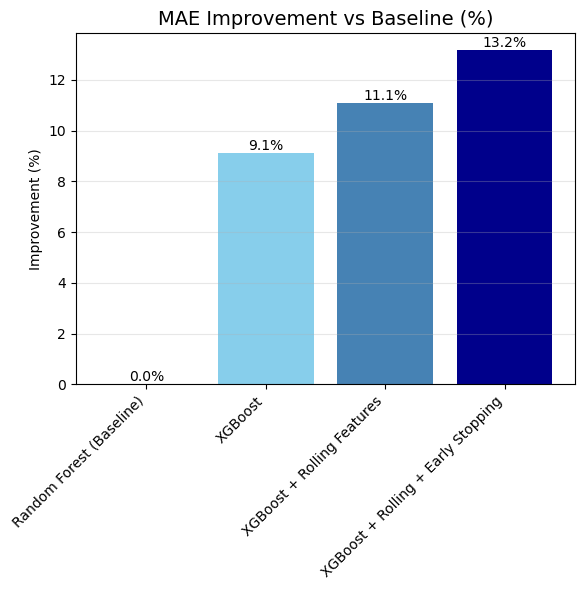

In [68]:
plt.figure(figsize=(6, 6))
bars = plt.bar(results['Model'], results['MAE_Improvement_%'], color=['lightgray', 'skyblue', 'steelblue', 'darkblue'])
plt.title('MAE Improvement vs Baseline (%)', fontsize=14)
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height ,
             f'{height:.1f}%', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/MAE Improvement vs Baseline.png', dpi=150, bbox_inches='tight')

plt.show()

# Saving Model 

In [63]:
xgb_best.save_model('../reports/walmart_sales_xgb.json')


feature_names = X_train.columns.tolist()
with open('../reports/feature_names.json', 'w') as f:
    json.dump(feature_names, f)  

metadata = {
    'model_version': 'v1',
    'training_date': datetime.now().isoformat(),
    'train_period': ['2010-02-19', '2011-12-30'],
    'val_period': ['2012-01-06', '2012-10-26'],
    'final_mae': 1408.34,
    'final_rmse': 3018.56,
    'model_type': 'XGBoost with early stopping'
}

with open('../reports/walmart_sales_xgb_metadata..json', 'w') as f:
    json.dump(metadata, f, indent=2)


joblib.dump(store_le, '../reports/le_store.pkl')
joblib.dump(dept_le, '../reports/le_dept.pkl')


print ("All Saved ..................!")

All Saved ..................!


## Loading model for predictions 

In [65]:
# Load model
xgb_loaded = xgb.XGBRegressor()
xgb_loaded.load_model('../reports/walmart_sales_xgb.json')

with open('../reports/walmart_sales_xgb_metadata..json', 'r') as f:
    metadata_loaded = json.load(f)

le_store = joblib.load('../reports/le_store.pkl')
le_dept = joblib.load('../reports//le_dept.pkl')
# Load features
with open('../reports/feature_names.json', 'r') as f:
    loaded_features = json.load(f)


# def preprocess(df):
#     df = df.copy()
#     df['Store'] = le_store.transform(df['Store'])   
#     df['Dept'] = le_dept.transform(df['Dept'])
    
#     return df[feature_names]

# Predict on validation set 
y_pred_loaded = xgb_loaded.predict(X_val[loaded_features])
mae_loaded = mean_absolute_error(y_val, y_pred_loaded)

print(f"Reproduced MAE: ${mae_loaded:,.2f}")  #  $1,408.34

Reproduced MAE: $1,408.34
